In [1]:
##############################################################################################################
# DESCRIPTION: 
#              
# RESULTS:     
#              
##############################################################################################################

In [2]:
######################
# CONFIG & HYPERPARAMS
######################

import os

class HyperParams:
    pass

IMG_PATH = "C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/"

hyperparams = HyperParams()
hyperparams.IMG_WIDTH = 64
hyperparams.IMG_HEIGHT = 64
hyperparams.EPOCHS = 400 # 600 #10000
hyperparams.BATCH_SIZE = 16
hyperparams.START_NEURONS = 8 # UNET
hyperparams.LOSS = 'mean_absolute_error'

IMG_WIDTH = hyperparams.IMG_WIDTH
IMG_HEIGHT = hyperparams.IMG_HEIGHT

IMG_CASE = str(IMG_WIDTH) +  "/0010_1000"
MODEL_NAME = "0010_1000-64-unet-xxn4"

IMG_PATH_VALID = IMG_PATH + "validation/"
IMG_PATH_TEST = IMG_PATH + "test/"
IMG_PATH_TRAIN = IMG_PATH

DEST_TESTS = os.path.abspath(os.path.join('../../../out_tests/', MODEL_NAME))

class RadianceLimits:
    pass
radiance_limits = RadianceLimits()
radiance_limits.noisy_min = 0
radiance_limits.noisy_max = 0.0299
radiance_limits.nitid_min = 0
radiance_limits.nitid_max = 0.4778

#from tensorflow.keras.optimizers import Adam
#hyperparams.OPTIMIZER = Adam(learning_rate=0.0001)
from tensorflow.keras.optimizers import Nadam
hyperparams.OPTIMIZER = Nadam(learning_rate=0.00005)
#from tensorflow.keras.optimizers import RMSprop
#hyperparams.OPTIMIZER = RMSprop(learning_rate = 0.0001)

In [3]:
##################
# IMPORTS
##################

import tensorflow as tf
from tensorflow.compat.v1 import InteractiveSession

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import numpy as np
import tensorflow 
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)
import os, sys
module_path = os.path.abspath(os.path.join('../../support/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import DatasetUtilsTifF as dsutils
import TrainModelD as train
import ReportsK as reports
import UnetI as model_factory

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(f"Tensorflow version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

tf.config.list_physical_devices('GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10476751730197047893
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5722079232
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15954907266548558189
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6"
]
Tensorflow version: 2.6.0
Keras Version: 2.6.0
GPU is available


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
##################
# MODEL DEFINITION
##################

model = model_factory.buildModel(hyperparams)
model.summary()
model.optimizer.get_config()

Loss=mean_absolute_error
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 8)    584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 8)    0           conv2d_1[0][0]                   
_____________________________________________________________________

{'name': 'Nadam',
 'learning_rate': 5e-05,
 'decay': 0.004,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07}

In [6]:
##################
# PREPARE DATA
##################

train_noisy_files, train_nitid_files, train_noisy, train_nitid = dsutils.readDataset( IMG_PATH_TRAIN, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)
val_noisy_files, val_nitid_files, val_noisy, val_nitid = dsutils.readDataset( IMG_PATH_VALID, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

train_noisy, train_nitid = dsutils.reshapeDataset( train_noisy, train_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )
val_noisy, val_nitid = dsutils.reshapeDataset( val_noisy, val_nitid, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/
Noisy files:20137
Nitid files:20137
Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/validation/
Noisy files:4872
Nitid files:4872


In [7]:
##################
# TRAIN MODEL
##################
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

checkpoint_filepath = os.path.abspath(os.path.join('../../../saves/') + MODEL_NAME \
                                      + "_checkpoint_" + '_weights_{epoch:02d}-{val_loss:.2f}')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

hist = train.fit( model, hyperparams, train_noisy, train_nitid, val_noisy, val_nitid, patience = 50, \
                 callbacks=[model_checkpoint_callback] )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6

Epoch 1/400
1259/1259 [==============================] - 51s 36ms/step - loss: 0.0913 - val_loss: 0.0711
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-unet-xxn4_checkpoint__weights_01-0.07\assets
Epoch 2/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0685 - val_loss: 0.0590
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-unet-xxn4_checkpoint__weights_02-0.06\assets
Epoch 3/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0655 - val_loss: 0.0576
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-unet-xxn4_checkpoint__weights_03-0.06\assets
Epoch 4/400
1259/1259 [==============================] - 46s 36ms/step - loss: 0.0639 - val_loss: 0.0554
INFO:tensorflow:Assets written to: C:\Projects\V

Epoch 67/400
1259/1259 [==============================] - 44s 35ms/step - loss: 0.0454 - val_loss: 0.0542
Epoch 68/400
1259/1259 [==============================] - 42s 34ms/step - loss: 0.0453 - val_loss: 0.0549
Epoch 69/400
1259/1259 [==============================] - 44s 35ms/step - loss: 0.0451 - val_loss: 0.0508
Epoch 70/400
1259/1259 [==============================] - 44s 35ms/step - loss: 0.0449 - val_loss: 0.0500
INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-unet-xxn4_checkpoint__weights_70-0.05\assets
Epoch 71/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0448 - val_loss: 0.0542
Epoch 72/400
1259/1259 [==============================] - 45s 35ms/step - loss: 0.0448 - val_loss: 0.0531
Epoch 73/400
1259/1259 [==============================] - 45s 35ms/step - loss: 0.0445 - val_loss: 0.0537
Epoch 74/400
1259/1259 [==============================] - 44s 35ms/step - loss: 0.0445 - val_loss: 0.0549
Epoch 75/400
1259/1259 [====

1259/1259 [==============================] - 45s 36ms/step - loss: 0.0372 - val_loss: 0.0525
Epoch 142/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0372 - val_loss: 0.0558
Epoch 143/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0372 - val_loss: 0.0519
Epoch 144/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0372 - val_loss: 0.0528
Epoch 145/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0369 - val_loss: 0.0525
Epoch 146/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0370 - val_loss: 0.0556
Epoch 147/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0369 - val_loss: 0.0537
Epoch 148/400
1259/1259 [==============================] - 44s 35ms/step - loss: 0.0366 - val_loss: 0.0529
Epoch 149/400
1259/1259 [==============================] - 45s 36ms/step - loss: 0.0365 - val_loss: 0.0517
Epoch 150/400
1259/1259 [==========================

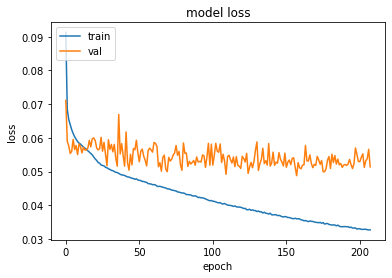

Best Epoch:158


In [8]:
##################
# REPORTS
##################

reports.plotHistory( hist )

In [9]:
model.save(os.path.abspath(os.path.join('../../../saves/', MODEL_NAME)), model)

INFO:tensorflow:Assets written to: C:\Projects\VenusDenoise\saves\0010_1000-64-unet-xxn4\assets


In [10]:
##################
# PREDICTIONS
##################
ACCURACY_THRESHOLD = 0.01
predictions_metrics, predictions_headers \
    = reports.calcPredictionMetrics( model, val_noisy, val_nitid, ACCURACY_THRESHOLD, \
                                    save_pred = True, save_path = DEST_TESTS, \
                                    noisy_files = val_noisy_files, nitid_files = val_nitid_files, \
                                    max_nitid= radiance_limits.nitid_max  )

Black image found
Black image found
Black image found
Black image found
Images count =4872
Best RMSENZ  =4478 (0.92)
Best MAENZ   =4510 (0.93)
Best PSNR    =4478 (0.92)
Best Accuracy=4203 (0.86)
RMSE-NZ  Pred=0.0565  Noisy=0.1609
MAE-NZ   Pred=0.0488  Noisy=0.1527
PSNR     Pred=16.5 dB Noisy=7.1 dB
Accuracy Pred=0.26    Noisy=0.08
SSM      Pred=0.89    Noisy=0.51
HOG MSE  Pred=0.09    Noisy=0.21


In [11]:
reports.saveMetrics( DEST_TESTS, MODEL_NAME, predictions_headers, predictions_metrics )

Read dataset. Path: C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test/
Noisy files:15
Nitid files:15
Index:0
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_1_nitid_idx076.tif


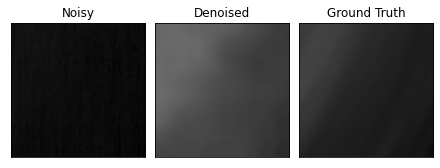

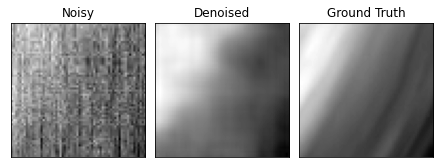

RMSE-NZ  Pred=0.1476  Noisy=0.1093 WORST
MAE-NZ   Pred=0.1458  Noisy=0.1013 WORST
PSNR     Pred=5.1 dB Noisy=7.7 dB WORST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.77    Noisy=0.28
HOG MSE  Pred=0.12    Noisy=0.40
******************************************************
Index:1
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_00_00_2_nitid_idx076.tif


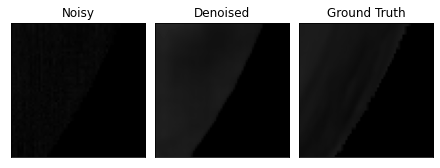

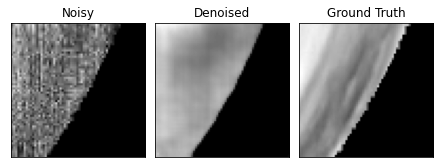

RMSE-NZ  Pred=0.0221  Noisy=0.0422 BEST
MAE-NZ   Pred=0.0139  Noisy=0.0346 BEST
PSNR     Pred=14.7 dB Noisy=9.1 dB BEST
Accuracy Pred=0.58    Noisy=0.23 BEST
SSM      Pred=0.93    Noisy=0.67
HOG MSE  Pred=0.08    Noisy=0.05
******************************************************
Index:2
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0044_01_00_8_nitid_idx076.tif


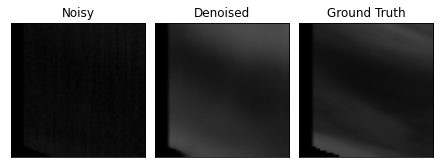

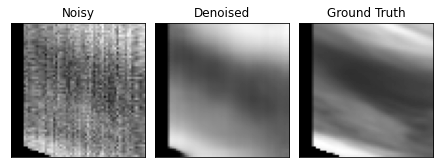

RMSE-NZ  Pred=0.0399  Noisy=0.0976 BEST
MAE-NZ   Pred=0.0330  Noisy=0.0842 BEST
PSNR     Pred=16.8 dB Noisy=9.1 dB BEST
Accuracy Pred=0.15    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.44
HOG MSE  Pred=0.05    Noisy=0.23
******************************************************
Index:3
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_00_5_nitid_idx076.tif


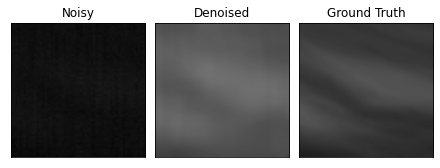

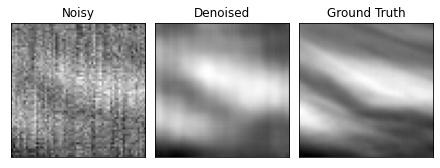

RMSE-NZ  Pred=0.1193  Noisy=0.1790 BEST
MAE-NZ   Pred=0.1180  Noisy=0.1749 BEST
PSNR     Pred=9.0 dB Noisy=5.4 dB BEST
Accuracy Pred=0.00    Noisy=0.00 WORST
SSM      Pred=0.89    Noisy=0.31
HOG MSE  Pred=0.07    Noisy=0.46
******************************************************
Index:4
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0066_01_01_6_nitid_idx076.tif


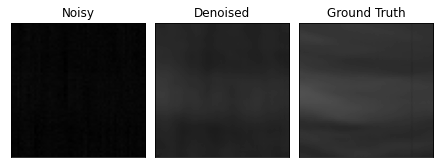

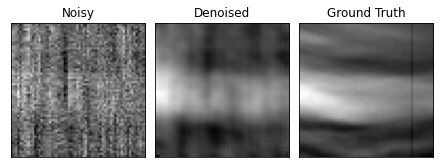

RMSE-NZ  Pred=0.0591  Noisy=0.1861 BEST
MAE-NZ   Pred=0.0561  Noisy=0.1834 BEST
PSNR     Pred=14.5 dB Noisy=4.6 dB BEST
Accuracy Pred=0.00    Noisy=0.00 BEST
SSM      Pred=0.92    Noisy=0.30
HOG MSE  Pred=0.15    Noisy=0.39
******************************************************
Index:5
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_00_4_nitid_idx076.tif


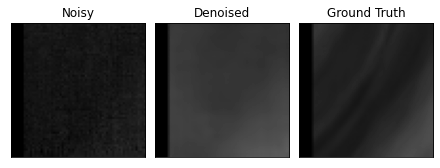

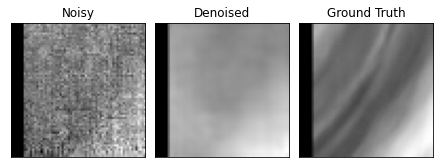

RMSE-NZ  Pred=0.0872  Noisy=0.0728 WORST
MAE-NZ   Pred=0.0778  Noisy=0.0602 WORST
PSNR     Pred=10.9 dB Noisy=12.4 dB WORST
Accuracy Pred=0.10    Noisy=0.04 BEST
SSM      Pred=0.80    Noisy=0.53
HOG MSE  Pred=0.13    Noisy=0.17
******************************************************
Index:6
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_00_01_13_nitid_idx076.tif


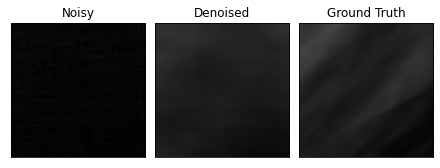

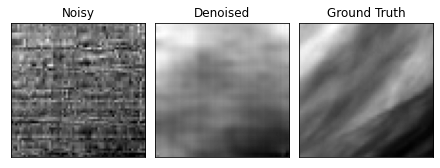

RMSE-NZ  Pred=0.0311  Noisy=0.1143 BEST
MAE-NZ   Pred=0.0240  Noisy=0.1044 BEST
PSNR     Pred=18.8 dB Noisy=7.5 dB BEST
Accuracy Pred=0.28    Noisy=0.00 BEST
SSM      Pred=0.86    Noisy=0.35
HOG MSE  Pred=0.16    Noisy=0.21
******************************************************
Index:7
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0157_01_00_3_nitid_idx076.tif


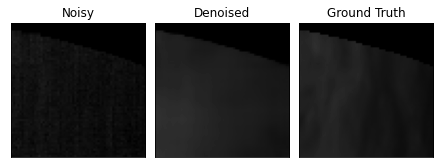

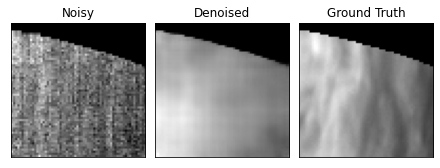

RMSE-NZ  Pred=0.0289  Noisy=0.0540 BEST
MAE-NZ   Pred=0.0220  Noisy=0.0470 BEST
PSNR     Pred=16.0 dB Noisy=10.6 dB BEST
Accuracy Pred=0.35    Noisy=0.08 BEST
SSM      Pred=0.90    Noisy=0.70
HOG MSE  Pred=0.08    Noisy=0.06
******************************************************
Index:8
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_11_nitid_idx076.tif


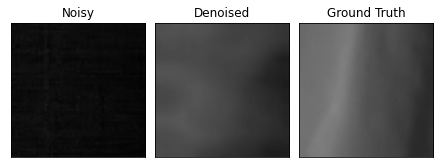

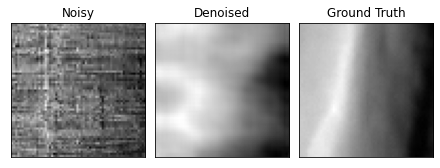

RMSE-NZ  Pred=0.1045  Noisy=0.3118 BEST
MAE-NZ   Pred=0.0905  Noisy=0.2974 BEST
PSNR     Pred=13.9 dB Noisy=4.4 dB BEST
Accuracy Pred=0.04    Noisy=0.00 BEST
SSM      Pred=0.85    Noisy=0.30
HOG MSE  Pred=0.18    Noisy=0.36
******************************************************
Index:9
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0164_03_01_9_nitid_idx076.tif


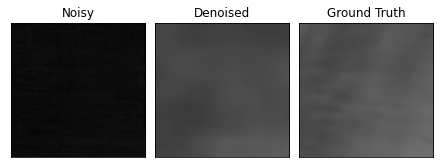

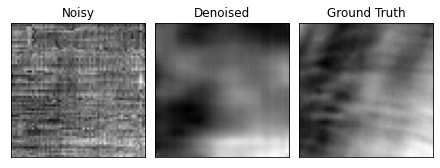

RMSE-NZ  Pred=0.0577  Noisy=0.2883 BEST
MAE-NZ   Pred=0.0531  Noisy=0.2864 BEST
PSNR     Pred=17.5 dB Noisy=3.5 dB BEST
Accuracy Pred=0.03    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.30
HOG MSE  Pred=0.11    Noisy=0.06
******************************************************
Index:10
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_7_nitid_idx076.tif


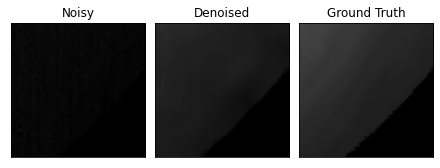

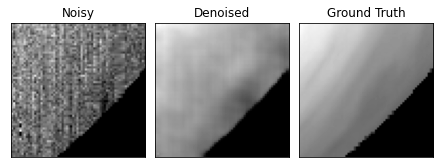

RMSE-NZ  Pred=0.0538  Noisy=0.1343 BEST
MAE-NZ   Pred=0.0451  Noisy=0.1226 BEST
PSNR     Pred=14.1 dB Noisy=6.2 dB BEST
Accuracy Pred=0.20    Noisy=0.11 BEST
SSM      Pred=0.89    Noisy=0.52
HOG MSE  Pred=0.07    Noisy=0.19
******************************************************
Index:11
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0231_05_01_8_nitid_idx076.tif


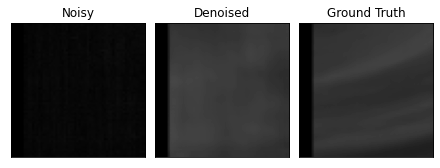

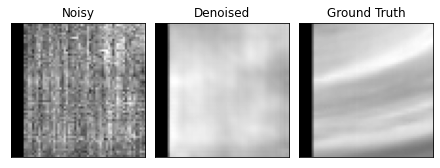

RMSE-NZ  Pred=0.0335  Noisy=0.1755 BEST
MAE-NZ   Pred=0.0261  Noisy=0.1729 BEST
PSNR     Pred=17.9 dB Noisy=3.5 dB BEST
Accuracy Pred=0.30    Noisy=0.00 BEST
SSM      Pred=0.96    Noisy=0.22
HOG MSE  Pred=0.12    Noisy=0.25
******************************************************
Index:12
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0242_08_00_15_nitid_idx076.tif


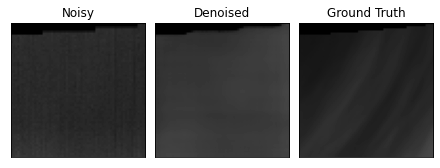

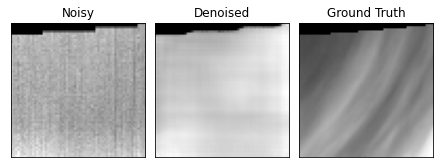

RMSE-NZ  Pred=0.0811  Noisy=0.0385 WORST
MAE-NZ   Pred=0.0747  Noisy=0.0294 WORST
PSNR     Pred=10.8 dB Noisy=17.3 dB WORST
Accuracy Pred=0.06    Noisy=0.25 WORST
SSM      Pred=0.82    Noisy=0.83
HOG MSE  Pred=0.13    Noisy=0.12
******************************************************
Index:13
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_noisy_idx068.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0272_04_00_9_nitid_idx076.tif


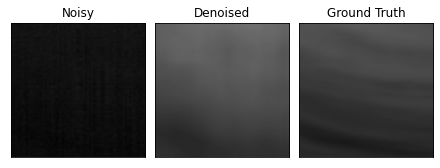

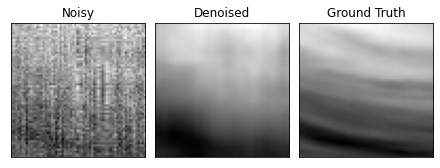

RMSE-NZ  Pred=0.0751  Noisy=0.1778 BEST
MAE-NZ   Pred=0.0715  Noisy=0.1697 BEST
PSNR     Pred=13.5 dB Noisy=6.0 dB BEST
Accuracy Pred=0.03    Noisy=0.00 BEST
SSM      Pred=0.93    Noisy=0.35
HOG MSE  Pred=0.08    Noisy=0.49
******************************************************
Index:14
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_noisy_idx089.tif
C:/Projects/VenusDenoise/dataset/cases/64/0010_1000/test\VI0376_06_01_13_nitid_idx076.tif


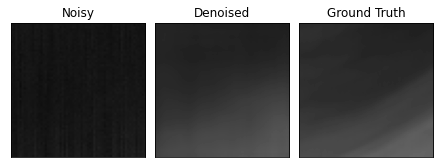

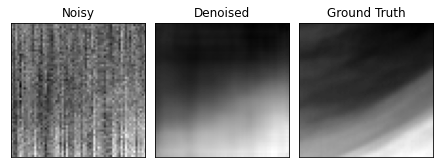

RMSE-NZ  Pred=0.0212  Noisy=0.1427 BEST
MAE-NZ   Pred=0.0169  Noisy=0.1285 BEST
PSNR     Pred=25.3 dB Noisy=8.8 dB BEST
Accuracy Pred=0.37    Noisy=0.00 BEST
SSM      Pred=0.97    Noisy=0.67
HOG MSE  Pred=0.05    Noisy=0.31
******************************************************


In [12]:
test_noisy_files, test_nitid_files, test_noisy, test_nitid = \
    dsutils.readDataset( IMG_PATH_TEST, hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT, radiance_limits)

test_noisy, test_nitid = \
    dsutils.reshapeDataset( test_noisy, test_nitid,  hyperparams.IMG_WIDTH, hyperparams.IMG_HEIGHT )

test_indexes = np.arange(0,test_noisy.shape[0])

reports.predictByIndexes( model, test_noisy, test_nitid, test_noisy_files, test_nitid_files, test_indexes, ACCURACY_THRESHOLD )